Importando os dados de Iris para os treinos

In [ ]:
!gdown https://drive.google.com/uc?id=1d3NbjXro_BfnYpFm66ETBfe7ubAZPAoL

Downloading...
From: https://drive.google.com/uc?id=1d3NbjXro_BfnYpFm66ETBfe7ubAZPAoL
To: /content/Iris.csv
100% 5.11k/5.11k [00:00<00:00, 3.74MB/s]


In [ ]:
from numpy.random import shuffle 

f = open('Iris.csv', 'r')
lines = f.readlines()

X = list()
Y = list()

cats = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

for line in lines[1:]:
  _, sl, sw, pl, pw, sp = line[:-1].split(',')
  
  sl = float(sl)
  sw = float(sw)
  pl = float(pl)
  pw = float(pw)
  
  sp = [ 1.0 if sp == cat else 0.0 for cat in cats ]

  X.append([sl,sw,pl,pw])
  Y.append(sp)


total = len(X)
indexes = list(range(total))

shuffle(indexes)

Xs = [X[i] for i in indexes]
Ys = [Y[i] for i in indexes]

# total = len(X)
sep = int(total * 0.1)

total_train = total - sep
total_test = sep 

Xt = Xs[:total_train,:]
Yt = Ys[:total_train,:]

Xv = Xs[total_train:,:]
Yv = Ys[total_train:,:]

Começando a usar PyTorch

In [ ]:
from matplotlib import pyplot as plt 
import torch

Aplicando a descida do gradiente em pyTorch em dados aleatórios

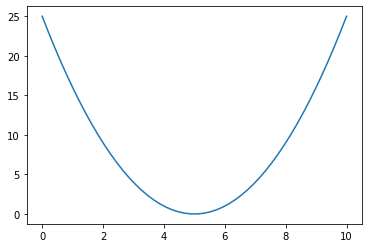

In [ ]:
x = torch.linspace(0,10, steps=50)
y = (x-5)**2

plt.plot(x,y)
plt.show()

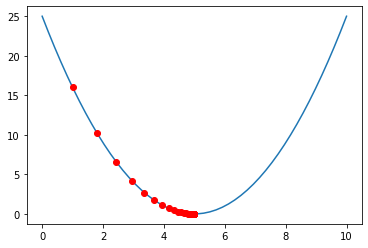

In [ ]:
f = lambda x: (x-5)**2 

x_ref = torch.linspace(0,10, steps=50)
y_ref = f(x_ref)

plt.plot(x_ref, y_ref)

x = torch.tensor(1.0, requires_grad=True) #x.requires_grad_(True)

for _ in range(50):
  y = f(x)

  plt.plot(x.data, y.data, 'ro')

  y.backward()
  x.data -= 0.1 * x.grad
  x.grad.zero_()


plt.show()

Dados do Iris com PyTorch

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [ ]:
class Perceptron(nn.Module):
  def __init__(self):
    super(Perceptron, self).__init__()
    self.wb1 = nn.Linear(4, 8)
    self.wb2 = nn.Linear(8, 3)
  
  def forward(self, x):
    s1 = self.wb1(x) 
    z1 = torch.sigmoid(s1)

    s2 = self.wb2(z1)
    z2 = s2              # Calculo do softmax depois
    return z2

In [ ]:
p = Perceptron()
print(p)

Perceptron(
  (wb1): Linear(in_features=4, out_features=8, bias=True)
  (wb2): Linear(in_features=8, out_features=3, bias=True)
)


In [ ]:
list(p.parameters())

[Parameter containing:
 tensor([[-0.4202,  0.4415, -0.2926, -0.3635],
         [ 0.2476, -0.0424, -0.3594, -0.4944],
         [-0.1747,  0.2987, -0.4852, -0.2437],
         [ 0.0701, -0.2205,  0.0031,  0.1966],
         [ 0.0059,  0.0556, -0.3233, -0.3687],
         [-0.1975, -0.2321,  0.0598, -0.3200],
         [ 0.4217, -0.4723,  0.4661,  0.2858],
         [ 0.0918,  0.1697, -0.2174, -0.2779]], requires_grad=True),
 Parameter containing:
 tensor([-0.1419, -0.4049,  0.1045, -0.3270,  0.1408, -0.3168, -0.0489, -0.2187],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.1247,  0.1733,  0.2434,  0.3409,  0.2668,  0.0982,  0.2830,  0.2362],
         [-0.2715, -0.2644, -0.1125, -0.1128, -0.3031,  0.2160,  0.2594,  0.3497],
         [ 0.3214, -0.0883,  0.1103, -0.0320,  0.2552,  0.2640,  0.2491, -0.1466]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.3437,  0.0800, -0.1413], requires_grad=True)]

In [ ]:
x = torch.tensor([[1.0, 2.0, 3.0, 4.0]])
y = p(x)

y_hat = torch.tensor([[0.0, 1.0, 0.0]])

loss = nn.CrossEntropyLoss()

e = loss(y, y_hat.argmax(dim=1)) # .argmax(dim=1) para pegar o index do onehot 

print(e)


tensor(1.0648, grad_fn=<NllLossBackward>)


In [ ]:
p.zero_grad()
e.backward()

for param in p.parameters():
  param.data -= 0.1 * param.grad

In [ ]:
for i in range(10001):
  for x, y_hat in zip(Xt, Xt):
    x = x.view(1,4)
    y_hat = y.view(1,3)
    
    p.zero_grad()
    
    y = p(x)
    
    e = loss(y, y_hat.argmax(dim=1))
    e.backward()
    
    for param in p.parameters():
      param.data -= 0.1*param.grad.data
    
    if not (i%1000) or i == 0:
      print(e)

In [ ]:
import torch.optim as optim 

optimizer = optim.SGD(p.parameters(), lr = 0.1)

for i in range(10001):
  optimizer.zero_grad()
  Y = p(Xt)
  e = loss(Y, Yt.argmax(dim=1))
  e.backward()
  optimizer.step()
  if not (i%1000) or i == 0 : 
    print(e)

In [ ]:
gpu = torch.device('cuda0') #sla
p.to(gpu)
Xt = Xt.to(gpu)
Yt = Yt.to(gpu)

In [ ]:
Xv = Xv.to(gpu)
Yv = Yv.to(gpu)

In [ ]:
y = F.softmax(p(Xv), dim = 1)
for y,y_hat in zip(Y,Yv):
  print(y, y_hat)


Keras 

In [ ]:
import numpy as np
from tensorflow import keras 
from tensorflow.keras import layers 

#np.set_printoptions(formater = {'float' : lambda x : '%+01.2f' %x})

In [ ]:
model = keras.Sequential(
    [
     keras.Input(shape=(4)),
     layers.Dense(8, activation='sigmoid'),
     layers.Dense(3, activation='softmax')
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


Compilar os dados

In [ ]:
model.compile(loss='categorical_crossentropy', \
              optimizer = 'adam', metrics = ['accuracy']
              )

In [ ]:
model.fit(X, Y, batch_size=140, epochs=10001, verbose=False)